# Aperture photometry.

In [52]:
import numpy as np
import matplotlib as mp
import ccdproc,os,sys,time,random
from glob import glob
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.time import Time
from astropy.wcs import WCS
import astroalign as aa
from astropy.nddata import CCDData
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.visualization import ImageNormalize, LogStretch
from matplotlib.ticker import LogLocator
from astropy.stats import SigmaClip, mad_std
from photutils.background import Background2D, MeanBackground,SExtractorBackground
from photutils import find_peaks, CircularAperture, CircularAnnulus, aperture_photometry
from photutils.centroids import centroid_2dg
from astropy.stats import SigmaClip, mad_std
from photutils import Background2D, MedianBackground, DAOStarFinder,IRAFStarFinder
from photutils.utils import calc_total_error
from photutils.detection import DAOStarFinder

/tmp/ipykernel_37833/3565177076.py:17: DeprecationWarning: `photutils.find_peaks` is a deprecated alias for `photutils.detection.find_peaks` and will be removed in the future. Instead, please use `from photutils.detection import find_peaks` to silence this warning.
  from photutils import find_peaks, CircularAperture, CircularAnnulus, aperture_photometry
/tmp/ipykernel_37833/3565177076.py:17: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import find_peaks, CircularAperture, CircularAnnulus, aperture_photometry
/tmp/ipykernel_37833/3565177076.py:17: DeprecationWarning: `photutils.CircularAnnulus` is a deprecated alias for `photutils.aperture.CircularAnnulus` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAnnulus` to silence this 

Filename: /home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_5.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      84   (2048, 2048)   float32   


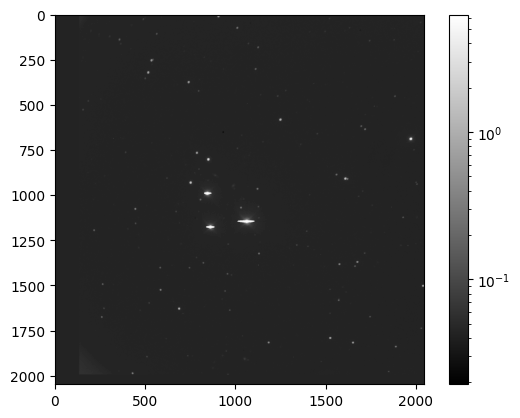

In [53]:

from astropy.io import fits
import pylab as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt

# Open the FITS file
file = fits.open('~/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_5.fits')

# Display information about the FITS file
file.info()

# Get the data from the FITS file
data = file[0].data

# Display the data using Matplotlib
plt.imshow(data, cmap='gray', norm=LogNorm())
plt.colorbar()
plt.show()

# Optionally, open and display another FITS file
# another_file = fits.open('science_aligned_10.fits')
# another_data = another_file[0].data
# plt.imshow(another_data, cmap='gray', norm=LogNorm())
# plt.colorbar()
# plt.show()


In [83]:
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

file_path = '~/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_5.fits'
# Get data and header from FITS file
data, header = fits.getdata(file_path, header=True)
# Extract exposure time from the header
exposure = header['EXPOSURE']

# Select a subset of the data (e.g., rows 600 to 1200, columns 600 to 1200)
data = data[10:2048, 10:2048]

# Perform sigma-clipped statistics
mean, median, std = sigma_clipped_stats(data, sigma=3.0, maxiters=20)

# Print the results
print("Mean:", mean)
print("Median:", median)
print("Standard deviation:", std)


Mean: 0.04353138
Median: 0.04353999
Standard deviation: 0.0012576729


In [84]:
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(data, (100, 100), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)



In [85]:
back=bkg.background # this is the background we need for the background subtraction.
back2,std2=np.median(bkg.background),np.std(bkg.background),
print('median background is',back2)
print('standard deviation of background is',std2)

median background is 0.04341566366872414
standard deviation of background is 0.0004019702539840481


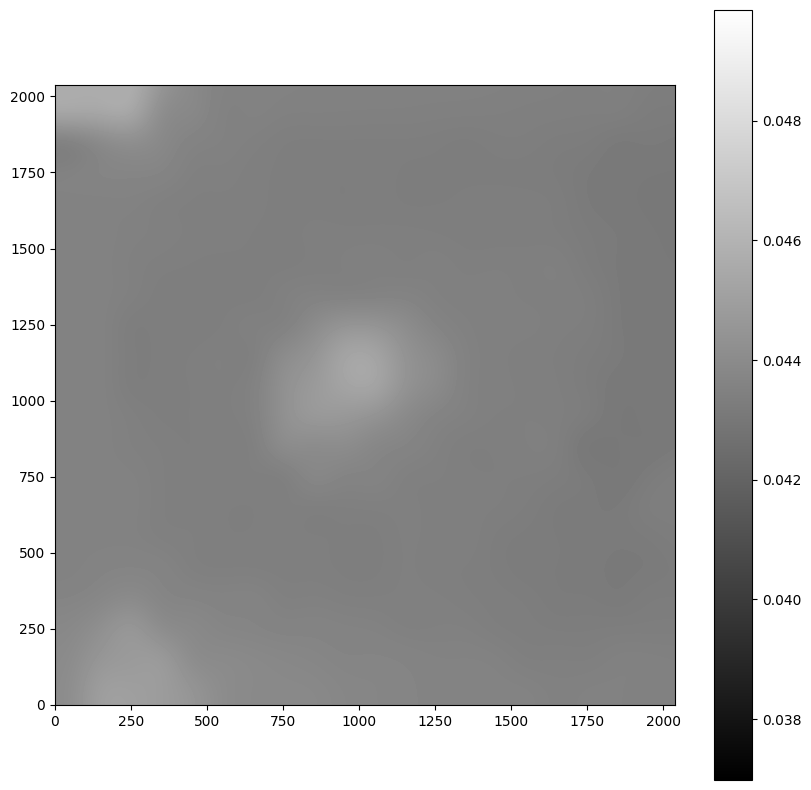

In [86]:
plt.figure(figsize=(10,10)) 
plt.imshow(bkg.background,vmin = back2 - 16*std2, vmax = back2 + 16*std2, origin='lower',cmap='gray')
plt.colorbar()
plt.show()

In [1]:
print('Finding the sources')
iraffind= IRAFStarFinder(threshold=5*std,fwhm=3) # search for this value
sources= iraffind(data-back)
print('We have found:',len(sources),' sources')

Finding the sources


NameError: name 'IRAFStarFinder' is not defined

In [103]:
px,py=sources['xcentroid'], sources['ycentroid']
positions=np.transpose((sources['xcentroid'], sources['ycentroid']))
fwhm=sources['fwhm']
FWHM = np.mean(fwhm)
print(FWHM)

3.1972237243279387


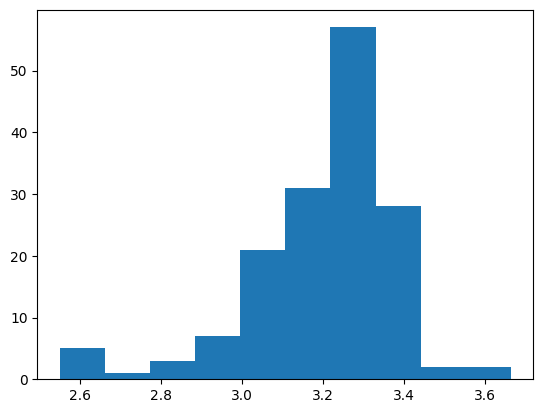

In [104]:
plt.hist(fwhm)
plt.show()

In [105]:

fwhm=FWHM
radii=[1,2,3,4,5]
#positions=(sources['xcentroid'], sources['ycentroid'])
apertures = [CircularAperture(positions, r=r*fwhm) for r in radii]
an_ap = CircularAnnulus(positions, r_in=6*fwhm, r_out=8*fwhm)
#apers = [apertures, annulus_apertures]

    

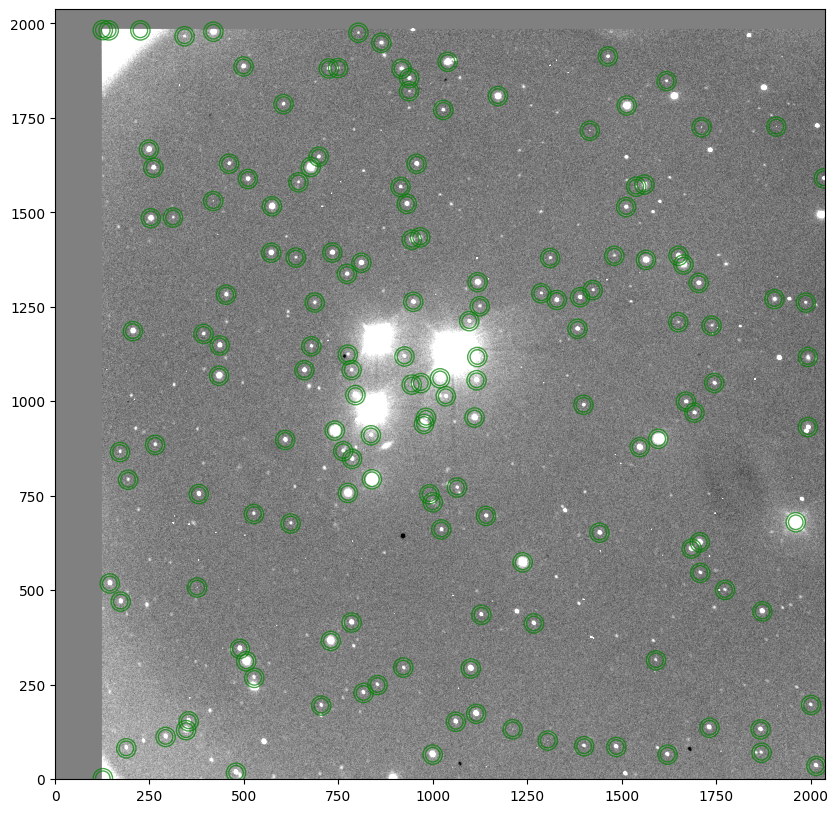

In [106]:




plt.figure(figsize=(10,10))
plt.imshow(data,cmap='gray',origin='lower',vmin=mean-4*std,vmax=mean+4*std)
colors=['maroon','salmon','yellow','blue','cyan']
#for i in range(len(apertures)):
 #   apertures[i].plot(color=colors[i], alpha=0.7)

an_ap.plot(color='green', alpha=0.7)
plt.show()



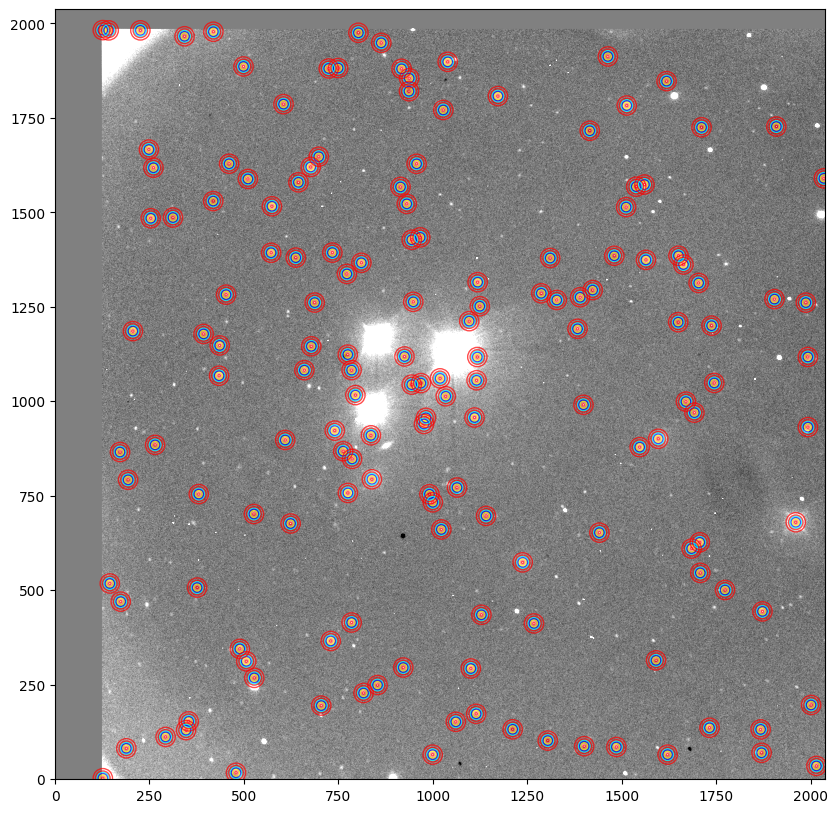

In [107]:
plt.figure(figsize=(10,10))
plt.imshow(data,cmap='gray',origin='lower',vmin=mean-4*std,vmax=mean+4*std)
colors=['red','salmon','yellow','blue','cyan']
for i in range(len(apertures)):
      apertures[i].plot(color=colors[i], alpha=0.7)

an_ap.plot(color='red', alpha=0.7)
plt.show()

In [111]:
bkg_sigma=mad_std(data)
effective_gain=exposure
error=calc_total_error(data,back,effective_gain)
error=0.1*data
phot_table = aperture_photometry(data-back, apertures,error=error)
phot_table2=aperture_photometry(data-back,an_ap)

bkg_mean = phot_table2['aperture_sum'] / an_ap.area
bkg_sum = bkg_mean * an_ap.area

final_sum0=phot_table['aperture_sum_0']-bkg_sum
final_sum1=phot_table['aperture_sum_1']-bkg_sum
final_sum2=phot_table['aperture_sum_2']-bkg_sum
final_sum3=phot_table['aperture_sum_3']-bkg_sum
final_sum4=phot_table['aperture_sum_4']-bkg_sum
print(final_sum0,final_sum1,final_sum2,final_sum3,final_sum4)

   aperture_sum_0   
--------------------
 -1.0377616035990544
  0.9596149436622001
  0.3638941031229104
    5.91852456658011
   0.461083859920328
 0.05532637400029704
-0.06721365018158798
 0.47749947859412345
 0.18317838022371907
0.037159980546885865
                 ...
 -0.6085546501973507
  1.5090105491689383
  0.6449084329647676
  0.6220423904291609
 0.47243882194118986
0.020314669156183657
  0.2249056406319237
    9.70894667629056
 -2.9409750352213018
 -1.7826717203895317
  -1.425273504828031
Length = 157 rows    aperture_sum_1   
--------------------
  -0.642901310728159
   2.193647492426554
  0.9669418718835475
   12.08257241602447
  0.9314676019547007
 0.21803216822528415
   0.267438002253256
  1.0102460810285496
 0.40659235309174313
0.009384315413207734
                 ...
 -0.5092289701728593
  2.3533560140634178
  2.0602693996843184
  0.8343498939962165
  0.8159195170953494
 0.15196392888397117
 0.27934979380785946
  14.772817326950653
  -2.168954956167828
 -1.371238949226

Now, we have the total flux for different apertures. To convert these flux to magnitudes we ca use:



```
apparent_magnitude = -2.5log(final_sum) + zp
```


where zp is the photometric zero point for a given aperture, calculated from apparent magnitudes of the known sources.

We need to figure out how manu known sources are available in the field, and then get their magnitudes.

In [109]:
#zp=25 for the time being, need to search for a better alternative for this. Or how to justify this aspect.
#mag_back=-2.5*np.log10(bkg_mean/exposure)
zp=23
mag_0=-2.5*np.log10(final_sum0/exposure)+zp
mag_1=-2.5*np.log10(final_sum1/exposure)+zp
mag_2=-2.5*np.log10(final_sum2/exposure)+zp
mag_3=-2.5*np.log10(final_sum3/exposure)+zp
mag_4=-2.5*np.log10(final_sum4/exposure)+zp

flux_err_0=phot_table['aperture_sum_err_0']
mag_err_0=1.09*flux_err_0/final_sum0

flux_err_1=phot_table['aperture_sum_err_1']
mag_err_1=1.09*flux_err_1/final_sum1

flux_err_2=phot_table['aperture_sum_err_2']
mag_err_2=1.09*flux_err_2/final_sum2


flux_err_3=phot_table['aperture_sum_err_3']
mag_err_3=1.09*flux_err_3/final_sum3

flux_err_4=phot_table['aperture_sum_err_4']
mag_err_4=1.09*flux_err_4/final_sum4

   

/tmp/ipykernel_37833/553264026.py:4: RuntimeWarning: invalid value encountered in log10
  mag_0=-2.5*np.log10(final_sum0/exposure)+zp
/tmp/ipykernel_37833/553264026.py:5: RuntimeWarning: invalid value encountered in log10
  mag_1=-2.5*np.log10(final_sum1/exposure)+zp
/tmp/ipykernel_37833/553264026.py:6: RuntimeWarning: invalid value encountered in log10
  mag_2=-2.5*np.log10(final_sum2/exposure)+zp
/tmp/ipykernel_37833/553264026.py:7: RuntimeWarning: invalid value encountered in log10
  mag_3=-2.5*np.log10(final_sum3/exposure)+zp
/tmp/ipykernel_37833/553264026.py:8: RuntimeWarning: invalid value encountered in log10
  mag_4=-2.5*np.log10(final_sum4/exposure)+zp


The curve of growth which provides an optimum aperture in which we have to extract our photometric fluxes will be done next.

In [110]:
print(mag_0,mag_1,mag_2,mag_3,mag_4)


  aperture_sum_0  
------------------
               nan
29.237560630734798
30.290365591966093
 27.26226950025173
30.033353336402563
 32.33547261630013
               nan
29.995370882569475
31.035617600800496
 32.76761444187393
               ...
               nan
28.746072447184826
29.669057997037136
 29.70825318270007
30.006939192059306
  33.4232787522516
 30.81280226761204
 26.72487284717031
               nan
               nan
               nan
Length = 157 rows   aperture_sum_1  
------------------
               nan
 28.33988603676289
 29.22930221911751
26.487404619970892
29.269883751834417
 30.84650170264902
  30.6247453381956
 29.18173520081887
 30.16990512062901
34.261796646086744
               ...
               nan
28.263584057015063
28.407993106329375
29.389432599039015
29.413684832455033
 31.23845185354462
30.577432248956065
26.269144817803426
               nan
               nan
               nan
Length = 157 rows   aperture_sum_2  
------------------
              

In [9]:
import numpy as np
import sep
from astropy.io import fits
import sep
from astropy.nddata import CCDData
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import re
from astropy.io import ascii
from astropy.table import Table, join, join_distance, vstack
from pylab import *
from astropy.io import fits
from PyAstronomy import pyasl
from matplotlib.pyplot import figure
import glob
import scipy
from scipy import (signal,stats,interpolate)
from astropy.coordinates import SkyCoord
from matplotlib.patches import Ellipse, Circle
from matplotlib.patches import Annulus
from astropy.time import Time
#from convenience_functions import show_image
import fitsio
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.io import fits

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]


















# Read the FITS image
dir="/home/osama/Downloads/ARIES/Test/"
image_data =glob.iglob(dir+'/DATA_1.3mDFOT_Osama/science_aligned_*.fits')
# Background subtraction
bkg = sep.Background(image_data)
data_sub = image_data - bkg

# Object detection
objects = sep.extract(data_sub, 3.0, err=bkg.globalrms, minarea=8)

# Assuming you have information about the target and companion stars
# For example, their coordinates (target_x, target_y) and (companion_x, companion_y)

# Find the closest detected object to the target star
target_object_index = np.argmin(np.sqrt((objects['x'] - target_x)**2 + (objects['y'] - target_y)**2))

# Find the closest detected object to the companion star
companion_object_index = np.argmin(np.sqrt((objects['x'] - companion_x)**2 + (objects['y'] - companion_y)**2))

# You may further refine this based on additional criteria such as brightness, proximity, etc.

# Accessing properties of detected objects
target_star_properties = objects[target_object_index]
companion_star_properties = objects[companion_object_index]

# Further processing based on your requirements


ModuleNotFoundError: No module named 'fitsio'

In [20]:
import numpy as np
from astropy.io import fits
import sep
import matplotlib.pyplot as plt

# Read the FITS image data
dir="/home/osama/Downloads/ARIES/Test/"
image_data =glob.iglob(dir+'/DATA_1.3mDFOT_Osama/science_aligned_*.fits')
# Convert image to float32 (required by SEP)
#image_data = image_data.astype(np.float32)
image_data = np.array(image_data)

# Extract sources using SEP
bkg = sep.Background(image_data)
sources = sep.extract(image_data, 3.0, err=bkg.globalrms)

i# Ensure the array has two dimensions
if len(image_data.shape) != 2:
    # Reshape the array if necessary
    image_data = np.reshape(image_data, (image_data.shape[0], -1))

# Convert the image data to a NumPy array
image_data = np.array(image_data, dtype=np.float32)

# Extract sources using SEP
bkg = sep.Background(image_data)
sources = sep.extract(image_data, 3.0, err=bkg.globalrms)

# Perform aperture photometry on each source
apertures = 3.0 * np.sqrt(sources['a'] * sources['b'])
flux, fluxerr, flag = sep.sum_circle(image_data, sources['x'], sources['y'], apertures)

# Calculate differential photometry
target_index = 0  # Index of the target star in the sources list
target_flux = flux[target_index]

reference_fluxes = np.delete(flux, target_index)  # Fluxes of reference stars
differential_fluxes = reference_fluxes - target_flux

# Optional: Visualize results
plt.imshow(image_data, cmap='gray', origin='lower')
plt.colorbar()
plt.scatter(sources['x'], sources['y'], marker='o', color='r', s=5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Detected Sources')
plt.show()

# Print differential fluxes
print("Differential Fluxes:", differential_fluxes)



ValueError: array must be 2-d